In [1]:
import logging
from itertools import combinations
import itertools
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx

from icecream import ic
import networkx as nx
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.DEBUG)


def tsp_cost(tsp):
    assert tsp[0] == tsp[-1] #ending point=starting point => cicle
    assert set(tsp) == set(range(len(CITIES))) #check that all the cities are visited

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost


"""Verifica se aggiungendo un segmento a `edges` si forma un ciclo"""
def cyclic(edges):
    G = nx.Graph()
    G.add_edges_from(edges)
    try:
        nx.find_cycle(G)
        return True
    except:
        return False
    
# Funzione per verificare se il grafo è ciclico
def is_cyclic(graph):
    return nx.is_connected(graph) and any(nx.simple_cycles(graph))

# Funzione per aggiungere un segmento
def add_segment(segments, cities, distance):
    city1, city2 = cities
    # Aggiungi city1 a segments
    if city1 not in segments:
        segments[city1] = {}
    # Aggiungi city2 a segments
    if city2 not in segments:
        segments[city2] = {}
    
    # Aggiungi la distanza tra city1 e city2
    segments[city1][city2] = distance
    segments[city2][city1] = distance  # Aggiungi la distanza anche in senso inverso

def generate_pair_permutations(nodes):
    # Genera tutte le permutazioni di coppie
    pair_permutations = list(itertools.permutations(nodes, 2))
    return pair_permutations

CITIES = pd.read_csv('cities/italy.csv', header=None, names=['name', 'lat', 'lon'])
#CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])

DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head(len(CITIES))



,name,lat,lon
0,Ancona,43.60,13.50
1,Andria,41.23,16.29
2,Bari,41.12,16.87
3,Bergamo,45.70,9.67
4,Bologna,44.50,11.34
5,Bolzano,46.50,11.35
6,Brescia,45.55,10.22
7,Cagliari,39.22,9.10
8,Catania,37.50,15.08
9,Ferrara,44.84,11.61


In [2]:
# Creazione dei segmenti possibili tra le città con le rispettive distanze
segments = [
    ({c1, c2}, float(DIST_MATRIX[c1, c2])) for c1, c2 in combinations(range(len(CITIES)), 2)
]

segments = sorted(segments, key=lambda e: e[1])  # Ordina i segmenti per distanza
shortest_cities=set()


visited = set()
edges = set()

count=0
# Selezione greedy dei segmenti
while len(visited) < len(CITIES):
    # Seleziona il segmento più corto che non forma un ciclo e non è già visitato
    shortest = next(
        s for s in segments 
        if not cyclic(edges | {tuple(s[0])}) and not (s[0].issubset(visited))
    )
    
    # Aggiorna visited ed edges
    visited |= shortest[0]
    edges.add(tuple(shortest[0]))

    city1, city2 = tuple(shortest[0])
    
    # Stampa il tratto del percorso
    logging.debug(f"Step: {CITIES.at[city1, 'name']} -> {CITIES.at[city2, 'name']} ({shortest[1]:.2f} km)")
    shortest_cities.add((frozenset(shortest[0]), shortest[1]))

    # Rimuove i segmenti che formerebbero un ciclo con i nuovi edges
    segments = [s for s in segments if not cyclic(edges | {tuple(s[0])})]


cities={}
for s in shortest_cities:
    city1,city2=s[0]
    #print(city1, city2)
    distance= s[1]
    add_segment(cities, (city1, city2), distance)
#print(cities)

DEBUG:root:Step: Naples -> Giugliano in Campania (11.15 km)
DEBUG:root:Step: Messina -> Reggio di Calabria (12.48 km)
DEBUG:root:Step: Milan -> Monza (14.51 km)
DEBUG:root:Step: Florence -> Prato (17.17 km)
DEBUG:root:Step: Reggio nell'Emilia -> Modena (23.94 km)
DEBUG:root:Step: Forlì -> Ravenna (26.46 km)
DEBUG:root:Step: Reggio nell'Emilia -> Parma (26.94 km)
DEBUG:root:Step: Vicenza -> Padua (30.13 km)
DEBUG:root:Step: Bergamo -> Monza (33.92 km)
DEBUG:root:Step: Venice -> Padua (36.07 km)
DEBUG:root:Step: Modena -> Bologna (37.29 km)
DEBUG:root:Step: Milan -> Novara (43.07 km)
DEBUG:root:Step: Ferrara -> Bologna (43.43 km)
DEBUG:root:Step: Verona -> Vicenza (44.70 km)
DEBUG:root:Step: Bergamo -> Brescia (46.02 km)
DEBUG:root:Step: Salerno -> Naples (46.25 km)
DEBUG:root:Step: Rimini -> Forlì (46.72 km)
DEBUG:root:Step: Trento -> Bolzano (49.94 km)
DEBUG:root:Step: Andria -> Bari (50.18 km)
DEBUG:root:Step: Catania -> Syracuse (51.23 km)
DEBUG:root:Step: Rome -> Latina (56.84 km)
D

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\user\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerifDisplay.ttf', name='DejaVu Serif Display', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='C:\\Users\\user\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono-BoldOblique.ttf', name='

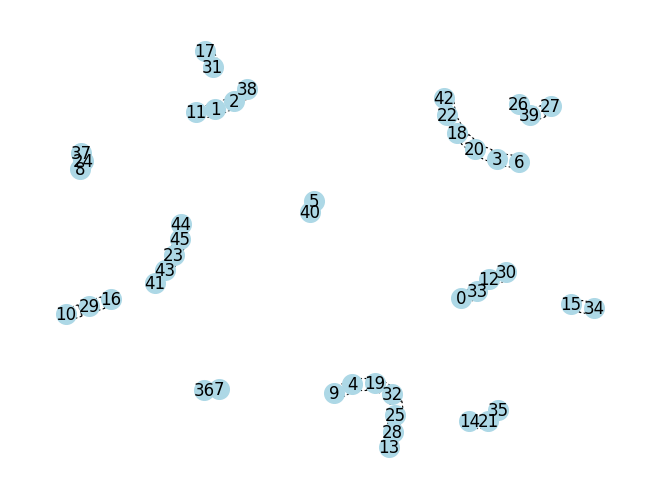

In [3]:
G = nx.Graph()

# Aggiunta dei segmenti
for start, ends in cities.items():
    for end, distance in ends.items():
        G.add_edge(start, end,) #weight=distance

# Visualizzazione del grafo
pos = nx.spring_layout(G)  # Posizionamento dei nodi
nx.draw(G, pos, with_labels=True, node_size=200, node_color='lightblue')
#labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos)#, edge_labels=labels
plt.show()

In [4]:
def find_min_distance_pairs(nodes):
    pair_permutations = generate_pair_permutations(nodes)
    min_pairs = []
    used_nodes = set()  # Per tenere traccia dei nodi già uniti

    for pair in pair_permutations:
        if pair[0] not in used_nodes and pair[1] not in used_nodes:
            # Trova l'indice dei nodi
            index1, index2 = pair
            print(index1, index2)
            #index2 = pair[1]
            distance = DIST_MATRIX[index1][index2]
            min_pairs.append((pair, distance))

    # Trova la coppia con la minima distanza
    min_pairs.sort(key=lambda x: x[1])  # Ordina per distanza
    return min_pairs

def find_connected_components(graph):
    # Trova i gruppi di nodi connessi
    return list(nx.connected_components(graph))

# Identifica i gruppi
connected_components = find_connected_components(G)

list_group=[]
# Stampa i gruppi
print("Gruppi di nodi connessi nel grafo:")
for i, component in enumerate(connected_components, 1):
    list_group.append(component)
    print(f"Gruppo {i}: {component}")

Gruppi di nodi connessi nel grafo:
Gruppo 1: {32, 4, 9, 13, 19, 25, 28}
Gruppo 2: {17, 31}
Gruppo 3: {3, 6, 42, 18, 20, 22}
Gruppo 4: {41, 43, 44, 45, 23}
Gruppo 5: {40, 5}
Gruppo 6: {8, 24, 37}
Gruppo 7: {0, 33, 12, 30}
Gruppo 8: {16, 10, 29}
Gruppo 9: {34, 15}
Gruppo 10: {1, 2, 11, 38}
Gruppo 11: {35, 21, 14}
Gruppo 12: {26, 27, 39}
Gruppo 13: {36, 7}


In [5]:
# Funzione per identificare le connessioni possibili tra i gruppi
def identify_cycle_connections(groups):
    connections = []  # Lista delle connessioni possibili

    # Condizione di connessione: se la somma di due nodi è un certo valore (es. 6)
    for i in range(len(groups)):
        for j in range(len(groups)):
            if i != j:  # Non confrontare lo stesso gruppo
                for node1 in groups[i]:
                    for node2 in groups[j]:
                         # Controlla se entrambi i nodi hanno solo 1 arco
                        if G.degree(node1) == 1 and G.degree(node2) == 1:
                            print(node1, node2)
                            connections.append((node1, node2, i, j))

    return connections

'''# Funzione per creare un ciclo
def create_cycle(groups, connections):
    cycle_edges = []
    used_groups = set()  # Per tenere traccia dei gruppi già utilizzati

    # Iniziamo da un gruppo e proviamo a formare il ciclo
    current_group = 0  # Iniziamo dal primo gruppo
    while len(used_groups) < len(groups):
        if current_group not in used_groups:
            used_groups.add(current_group)
            # Trova le connessioni da questo gruppo
            for connection in connections:
                node1, node2, group1_idx, group2_idx = connection
                if group1_idx == current_group and group2_idx not in used_groups:
                    cycle_edges.append((node1, node2))
                    current_group = group2_idx  # Passa al prossimo gruppo
                    break
            else:
                break  # Se non ci sono più connessioni, termina il ciclo
        else:
            current_group += 1  # Passa al gruppo successivo

    return cycle_edges

# Identifica le connessioni
connections = identify_cycle_connections(list_group)
print("-----------")
print(connections)
print("-----------")

# Crea un ciclo
cycle_edges = create_cycle(list_group, connections)


print(cycle_edges)
# Stampa le connessioni e gli archi del ciclo
print("Connessioni possibili per formare un ciclo:")
for connection in connections:
    node1, node2, group1_idx, group2_idx = connection
    print(f"Nodo {node1} da Gruppo {group1_idx + 1} può connettersi a Nodo {node2} da Gruppo {group2_idx + 1}")



print("\nArchi del ciclo creato:")
for edge in cycle_edges:
    G.add_edge(edge[0], edge[1])
    print(edge)

# Controlla se il grafo è ciclico
if is_cyclic(G):
    print("Il grafo è ciclico.")
else:
    print("Il grafo non è ciclico.")



pos = nx.spring_layout(G)  # Posizionamento dei nodi
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()'''

'# Funzione per creare un ciclo\ndef create_cycle(groups, connections):\n    cycle_edges = []\n    used_groups = set()  # Per tenere traccia dei gruppi già utilizzati\n\n    # Iniziamo da un gruppo e proviamo a formare il ciclo\n    current_group = 0  # Iniziamo dal primo gruppo\n    while len(used_groups) < len(groups):\n        if current_group not in used_groups:\n            used_groups.add(current_group)\n            # Trova le connessioni da questo gruppo\n            for connection in connections:\n                node1, node2, group1_idx, group2_idx = connection\n                if group1_idx == current_group and group2_idx not in used_groups:\n                    cycle_edges.append((node1, node2))\n                    current_group = group2_idx  # Passa al prossimo gruppo\n                    break\n            else:\n                break  # Se non ci sono più connessioni, termina il ciclo\n        else:\n            current_group += 1  # Passa al gruppo successivo\n\n    ret

Gruppi di nodi connessi nel grafo:
Gruppo 1: {32, 4, 9, 13, 19, 25, 28}
Gruppo 2: {17, 31}
Gruppo 3: {3, 6, 42, 18, 20, 22}
Gruppo 4: {41, 43, 44, 45, 23}
Gruppo 5: {40, 5}
Gruppo 6: {8, 24, 37}
Gruppo 7: {0, 33, 12, 30}
Gruppo 8: {16, 10, 29}
Gruppo 9: {34, 15}
Gruppo 10: {1, 2, 11, 38}
Gruppo 11: {35, 21, 14}
Gruppo 12: {26, 27, 39}
Gruppo 13: {36, 7}
9 17
9 31
13 17
13 31
9 6
9 42
13 6
13 42
9 41
9 44
13 41
13 44
9 40
9 5
13 40
13 5
9 24
9 37
13 24
13 37
9 0
9 30
13 0
13 30
9 16
9 10
13 16
13 10
9 34
9 15
13 34
13 15
9 11
9 38
13 11
13 38
9 35
9 14
13 35
13 14
9 26
9 27
13 26
13 27
9 36
9 7
13 36
13 7
17 9
17 13
31 9
31 13
17 6
17 42
31 6
31 42
17 41
17 44
31 41
31 44
17 40
17 5
31 40
31 5
17 24
17 37
31 24
31 37
17 0
17 30
31 0
31 30
17 16
17 10
31 16
31 10
17 34
17 15
31 34
31 15
17 11
17 38
31 11
31 38
17 35
17 14
31 35
31 14
17 26
17 27
31 26
31 27
17 36
17 7
31 36
31 7
6 9
6 13
42 9
42 13
6 17
6 31
42 17
42 31
6 41
6 44
42 41
42 44
6 40
6 5
42 40
42 5
6 24
6 37
42 24
42 37
6 0


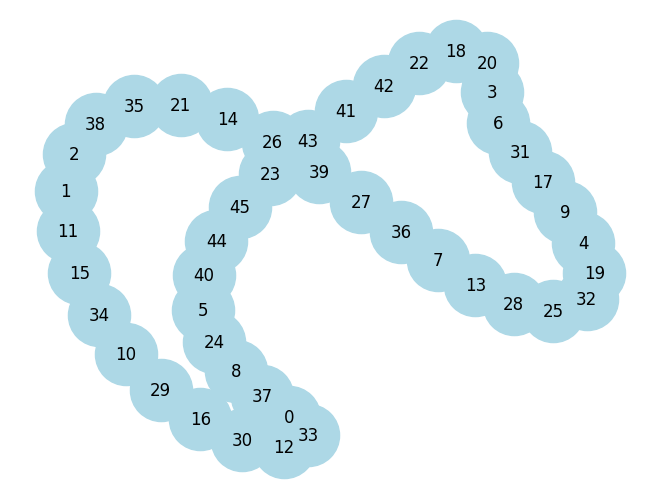

In [6]:


def create_cycle(groups, connections):
    cycle_edges = []
    used_groups = set()  # To track groups already used
    current_group = 0  # Start from the first group
    condition = False

    while not condition:
        if len(used_groups) < len(groups):
            if current_group not in used_groups:
                used_groups.add(current_group)
                
                # Find connections from this group
                for connection in connections[:]:  # Use a copy to avoid modifying during iteration
                    node1, node2, group1_idx, group2_idx = connection
                    
                    if group1_idx == current_group  and group2_idx not in used_groups:
                        cycle_edges.append((node1, node2))
                        print("---", (node1, node2))
                        
                        # Remove connections involving node1 or node2
                        connections = [c for c in connections if not (c[0] == node1 or c[1] == node1 or c[0] == node2 or c[1] == node2)]
                        
                        # Add the edge to the graph (assuming G is defined globally or passed as a parameter)
                        G.add_edge(node1, node2)
                        
                        # Check if adding this edge creates a cycle
                        condition = is_cyclic(G)
                        
                        # Move to the next group
                        current_group = group2_idx
                        break  # Exit for loop to avoid incrementing current_group in the next iteration
                else:
                    # If no connections were found for the current group, reset to next group
                    current_group += 1
            else:
                current_group += 1  # Move to the next group
        else:
            # Reset if all groups have been used and no cycle has been found
            used_groups.clear()
            current_group = 0

    return cycle_edges



# Identifying groups
connected_components = find_connected_components(G)
list_group = [component for component in connected_components]

# Print connected groups
print("Gruppi di nodi connessi nel grafo:")
for i, component in enumerate(list_group, 1):
    print(f"Gruppo {i}: {component}")

# Identify connections
connections = identify_cycle_connections(list_group)
print("-----------")
print(connections)
print("-----------")

# Create a cycle
cycle_edges = create_cycle(list_group, connections)

# Print the cycle edges and add them to the graph
print("Archi del ciclo creato:")
for edge in cycle_edges:
    G.add_edge(edge[0], edge[1])
    print(edge)




# Visualization
pos = nx.spring_layout(G)  # Node positioning
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

